In [56]:
import pandas as pd
import json
import ast
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter


In [57]:

# Step 1: Read the parquet file
df_from_parquet = pd.read_parquet(r"C:\Users\ranjan.patra\OneDrive - Lingaro Sp. z o. o\DATA\IITJ\Course\Projects\ISL\ISL_CSLRT_Corpus\Mp_Data\LandMarks_lh_rh")

# Step 2: Create a mapping of unique labels to unique IDs
unique_labels = df_from_parquet['Label'].unique()
label_id_mapping = {label: idx for idx, label in enumerate(unique_labels)}

# Step 3: Map the Label to Label_id in the DataFrame
df_from_parquet['Label_id'] = df_from_parquet['Label'].map(label_id_mapping)
label_info = [{'Label': label, 'Label_id': label_id} for label, label_id in label_id_mapping.items()]


# Step 4: Ensure Keypoints are converted to lists if they are not already
df_from_parquet['Keypoints'] = df_from_parquet['Keypoints'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# Step 5: Group by the necessary columns and aggregate
grouped = df_from_parquet.groupby(['Label','Label_id', 'sample_type', 'Sample_Number']).apply(
    lambda x: x[['Frame_Number', 'Keypoints']].to_dict('records')
).reset_index(name='frames_keypoints')

# Step 6: Convert the grouped result to a JSON-like structure
grouped_json = grouped.to_dict(orient='records')

# Step 7: Convert the result to a JSON string
json_output = json.dumps(grouped_json, indent=4)

# Print the JSON structure
#print(json_output)

# # (Optional) Save the result to a file
# with open('output.json', 'w') as f:
#     f.write(json_output)


In [58]:
data = json.loads(json_output)
print(data[5])

{'Label': 'No need to worry dont worry', 'Label_id': 62, 'sample_type': 'Video', 'Sample_Number': 0, 'frames_keypoints': [{'Frame_Number': 1.0, 'Keypoints': ['{0.4985485374927521, 0.37102603912353516, -0.6914837956428528}', '{0.5123894214630127, 0.3338186740875244, -0.6606837511062622}', '{0.5194430351257324, 0.3343222737312317, -0.6609050035476685}', '{0.5273507237434387, 0.3353610634803772, -0.6609714031219482}', '{0.4874161183834076, 0.3325340747833252, -0.6645382642745972}', '{0.47868168354034424, 0.3323493003845215, -0.6647102236747742}', '{0.47088518738746643, 0.3320005536079407, -0.6650708913803101}', '{0.5377077460289001, 0.35364025831222534, -0.4309026300907135}', '{0.45839041471481323, 0.34745270013809204, -0.44449490308761597}', '{0.5119916200637817, 0.41178983449935913, -0.602461040019989}', '{0.4827633798122406, 0.4091840386390686, -0.6067267060279846}', '{0.592089056968689, 0.5906533002853394, -0.2466043382883072}', '{0.3959070146083832, 0.5547084212303162, -0.27566808462

In [59]:
# Helper function to extract keypoints from strings
def extract_keypoints(keypoint_str):
    keypoint_str = keypoint_str.replace('{', '[').replace('}', ']')
    return ast.literal_eval(keypoint_str)

In [60]:
pose_connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Torso connections
    (0, 4), (4, 5), (5, 6), (6, 8),  # Left arm connections
    (9, 10),  # Right arm connections
    (11, 12),  # Additional arm connection
    (12, 14), (14, 16), (16, 18), (18, 20), (20, 16),  # Leg connections
    (16, 22),  # Hip connection
    (12, 24), (24, 26), (26, 28), (28, 30), (30, 32), (32, 28),  # Additional connections
    (11, 13), (13, 15), (15, 17), (17, 19), (19, 15),  # Additional connections
    (15, 21),  # Additional connection
    (11, 23), (23, 25), (25, 27), (27, 29), (29, 31), (31, 27),  # Additional connections
    (24, 23)   # Additional connection
]

In [61]:

# Define connections for hand keypoints based on provided indices
hand_connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),  # Thumb connections
    (0, 5), (5, 6), (6, 7), (7, 8),  # Index finger connections
    (0, 9), (9, 10), (10, 11), (11, 12),  # Middle finger connections
    (0, 13), (13, 14), (14, 15), (15, 16),  # Ring finger connections
    (0, 17), (17, 18), (18, 19), (19, 20)   # Pinky connections
]

In [62]:
def update(frame_idx):
    ax.clear()  # Clear previous plot
    frame = frames_data[frame_idx]
    keypoints = frame['Keypoints']
    
    # Split keypoints into three groups
    group1 = keypoints[:33]  # First 33 keypoints (Pose)
    group2 = keypoints[33:54]  # Next 21 keypoints (Left Hand)
    group3 = keypoints[54:75]  # Last 21 keypoints (Right Hand)

    # Extract x and y values for each group
    x_vals1, y_vals1 = zip(*[(kp[0], kp[1]) for kp in group1])  # Pose keypoints
    x_vals2, y_vals2 = zip(*[(kp[0], kp[1]) for kp in group2])  # Left Hand keypoints
    x_vals3, y_vals3 = zip(*[(kp[0], kp[1]) for kp in group3])  # Right Hand keypoints

    # Invert y values for upside down effect
    y_vals1 = [1 - y for y in y_vals1]
    y_vals2 = [1 - y for y in y_vals2]
    y_vals3 = [1 - y for y in y_vals3]

    # Invert x values for left-right effect (assuming the original x values are in range [0, 1])
    x_vals1 = [1 - x for x in x_vals1]
    x_vals2 = [1 - x for x in x_vals2]
    x_vals3 = [1 - x for x in x_vals3]

    # Plot the keypoints with different colors
    ax.scatter(x_vals1, y_vals1, color=scatter_colors[0], label="Pose (33 points)")
    ax.scatter(x_vals2, y_vals2, color=scatter_colors[1], label="Right hand (21 points)")
    ax.scatter(x_vals3, y_vals3, color=scatter_colors[2], label="Left hand (21 points)")
    
    # Connect the keypoints with lines for pose
    for start, end in pose_connections:
        ax.plot([x_vals1[start], x_vals1[end]], [y_vals1[start], y_vals1[end]], color='red')

    # Connect the keypoints with lines for hands
    for start, end in hand_connections:
        ax.plot([x_vals2[start], x_vals2[end]], [y_vals2[start], y_vals2[end]], color='orange')
        ax.plot([x_vals3[start], x_vals3[end]], [y_vals3[start], y_vals3[end]], color='yellow')

    # Set title with frame number and label name
    ax.set_title(f"{label_name} - Frame {frame['Frame_Number']}")
    
    # Display frame number in the plot as annotation
    ax.annotate(f"Frame: {frame['Frame_Number']}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12, color='red')
    
    # Set axis limits (adjust if needed)
    ax.set_xlim(0, 1)  # Assuming normalized values for x
    ax.set_ylim(0, 1)  # Assuming normalized values for y

    # Add a legend for clarity
    ax.legend()

GIF saved at He_is_going_into_the_room_Sample_0.gif


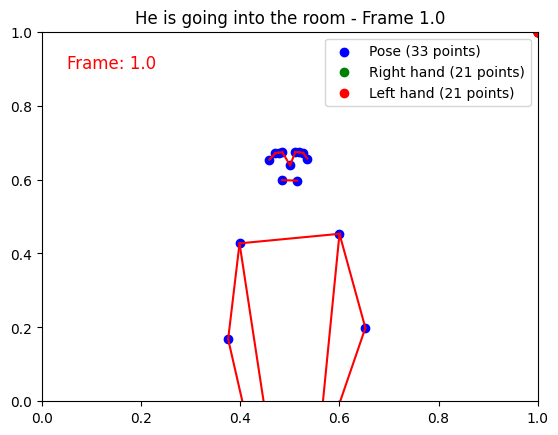

In [63]:

# Sample JSON-like structure
json_data = data[0]  # Assuming this contains frames_keypoints and the label
label_name = json_data['Label']  # Extract label name from the data
sample_number = json_data['Sample_Number']  # Extract sample number from the data
frames_keypoints = json_data['frames_keypoints']

# Prepare the keypoints data for each frame
frames_data = []
for frame in frames_keypoints:
    frame_number = frame['Frame_Number']
    keypoints = [extract_keypoints(kp) for kp in frame['Keypoints']]
    frames_data.append({'Frame_Number': frame_number, 'Keypoints': keypoints})

# Create figure for plotting
fig, ax = plt.subplots()

# Define colors for each group
scatter_colors = ['blue', 'green', 'red']
line_colors = ['red', 'yellow', 'orange']

# Create animation
anim = FuncAnimation(fig, update, frames=len(frames_data), interval=200)

# Create a GIF filename with label name and sample number
gif_name = f"{label_name.replace(' ', '_')}_Sample_{sample_number}.gif"
gif_path = gif_name

# Save animation as GIF
anim.save(gif_path, writer=PillowWriter(fps=5))  # Set fps (frames per second) as per your need

# Display message
print(f"GIF saved at {gif_path}")


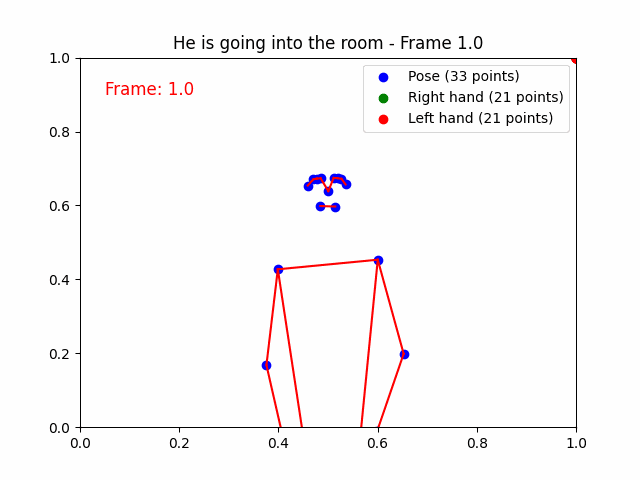

In [64]:
from IPython.display import Image

# Display the saved GIF
Image(filename=gif_path)


GIF saved at He_is_going_into_the_room_Sample_0.gif


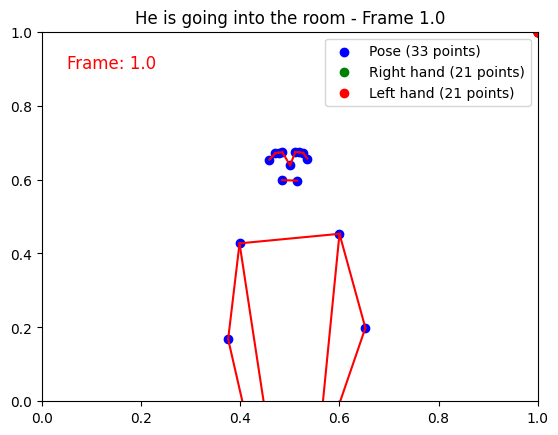